In [523]:
from IPython.display import Markdown as md
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.animation import FuncAnimation
import os
from scipy.io import loadmat
import math
import pandas as pd
from scipy.signal import butter,filtfilt, lfilter
from scipy import signal
from scipy.ndimage import convolve1d
from scipy.interpolate import interp1d

from scipy.signal import find_peaks
#!pip install sympy
from sympy import *

## Carico la matrice

In [524]:
percorso="/home/davide/Documents/FESI"
patient = '522_01_L_joints'  # nome del file (senza .mat)
# qui metti il path al file .mat sul tuo pc (compreso .mat)
data = loadmat(
    percorso+"/Pazienti/"+patient+".mat")
data_filter = data[list(data.keys())[-1]]


Do' un'occhiata ai grafici

In [525]:
print(data_filter)

[[460.83406177 254.2894195           nan ... 352.5456921  407.80697985
  358.39570636]
 [461.25182124 255.35780747          nan ... 353.23728363 408.42316475
  359.09784197]
 [460.11234146 255.51702517          nan ... 353.48095475 408.52650474
  359.35780276]
 ...
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]
 [         nan          nan          nan ...          nan          nan
           nan]]


Ci sono parecchi nan, vado a levare solo quelli agli estremi così dopo posso completare i valori mancanti all'interno dei grafici

In [526]:
#funzione per levare nan agli estremi
def nanRem(arr):
    start, end = 0, len(arr)-1
    while(np.isnan(arr[start])):
        start+=1
    while(np.isnan(arr[end])):
        end-=1
    newarray = np.array(arr[start:end])
    return newarray
        

In [527]:
anca_x = nanRem(data_filter[:,0])
anca_y = nanRem(data_filter[:,1])
ginocchio_x = nanRem(data_filter[:,2])
ginocchio_y = nanRem(data_filter[:,3])
caviglia_x = nanRem(data_filter[:,4])
caviglia_y = nanRem(data_filter[:,5])
piede_x = nanRem(data_filter[:,6])
piede_y = nanRem(data_filter[:,7])

segnali=[anca_x, anca_y, ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x, piede_y]
#fare la trasposta

Dopo aver diviso in liste le coordinate x e y di ogni punto e dopo aver levato i nan vado a plottare

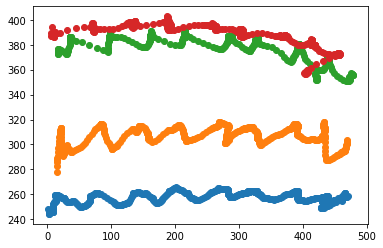

In [528]:
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

Oltre al fatto che il grafico è rovesciato, ci sono anche delle interferenze.

# Inverto l'asse y:

Semplicemente prendo ogni valore degli array contenenti le y e lo sottraggo al valore massimo globale 

In [529]:
def inverti_y(segnali):
    massimo = max(np.nanmax(segnali[1]), np.nanmax(segnali[3]), np.nanmax(segnali[5]), np.nanmax(segnali[7]))
    for i in (1,3,5,7):
        segnali[i]=massimo-segnali[i]    

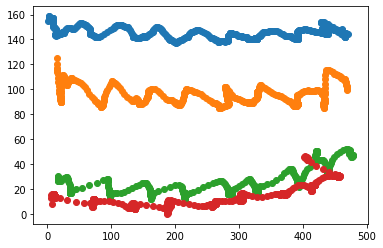

In [530]:
inverti_y(segnali)
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

plt.show()

# Inverto l'asse x:

Se la gamba che sto analizzando è la destra, è comodo invertire l'asse x per evitare che tutto sia specchiato:

In [531]:
def inverti_x(file, segnali):
    if "R" in file or "dx" in file:
        massimo = max(np.nanmax(segnali[0]), np.nanmax(segnali[2]), np.nanmax(segnali[4]), np.nanmax(segnali[6]))
        for i in (0,2,4,6):
            segnali[i]=massimo-segnali[i]   

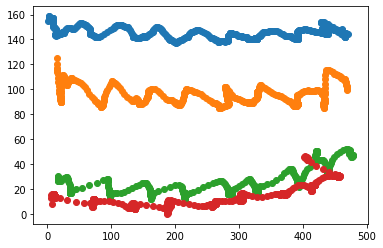

In [532]:
inverti_x(patient, segnali)
for i in (0,2,4,6):
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

plt.show()

# Correggo le interferenze con dei filtri

Prendo come esempio i valori x dell'anca per far vedere come operano i filtri plottando i risultati intermedi.

## Interpolazione

Interpolo i valori mancanti sostituendo i nan.

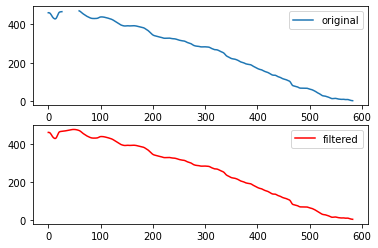

In [533]:
res=pd.Series(segnali[0]).interpolate(method='polynomial', order=2)

plt.figure()
plt.subplot(211)
plt.plot(segnali[0])
plt.legend(['original'])
#plt.title('original')
plt.subplot(212)

plt.plot(res, 'r')
plt.legend(['filtered'])
plt.show()

## Passa-basso

Applico un filtro passa-basso con frequenza 12Hz poichè il corpo umano non riesce a muoversi a questa frequenza e quindi i dati rilevati saranno sicuramente disturbi.

Faccio la trasformata di Fourier del mio segnale:

(-1.0, 100000.0)

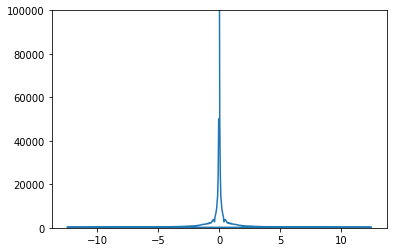

In [534]:
fs = 25
fft_f = np.fft.fft(res)
n = len(fft_f)
freq = np.fft.fftfreq(n, 1/fs)

plt.plot(freq,np.abs(fft_f))  
plt.ylim([-1,100000])

Applico il filtro levando le frequenze maggiori di 12Hz

(-1.0, 100000.0)

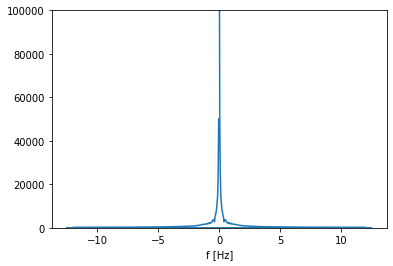

In [535]:
idx = np.argwhere(np.abs(freq)>12)
fft_cut=np.copy(fft_f)
fft_cut[idx]=0

plt.plot(freq,np.abs(fft_cut) )
plt.xlabel('f [Hz]')
plt.ylim([-1,100000])

Applico una trasformata di Furier inversa e plotto il segnale risultante

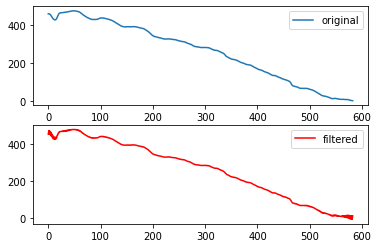

In [536]:
f_cut=np.fft.ifft(fft_cut)

plt.figure()
plt.subplot(211)
plt.plot(res)
plt.legend(['original'])
#plt.title('original')
plt.subplot(212)

plt.plot(np.real(f_cut),'r')
plt.legend(['filtered'])
plt.show()

## Mediano

Applico infine un filtro mediano per levare eventuali spike localizzati dovuti ad errori nella raccolta dei movimenti

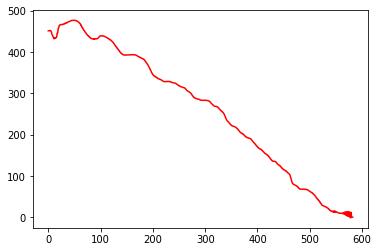

In [537]:
filt_med=signal.medfilt(np.real(f_cut), kernel_size=7) 
plt.plot(filt_med, 'r')

## Gaussiano

Ora applico un filtro gaussiano.

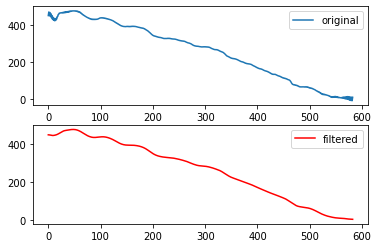

In [538]:
windowg = signal.windows.gaussian(23, std=10) #cambiare valori della gaussian
windowg /= sum(windowg)
filt = convolve1d(filt_med, windowg)

plt.figure()
plt.subplot(211)
plt.plot(np.real(f_cut))
plt.legend(['original'])
plt.subplot(212)
plt.plot(filt, 'r')
plt.legend(['filtered'])
plt.show()

## Filtri applicati sugli altri segnali

Ora faccio le stesse operazioni su tutti gli altri segnali (anca_y , ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x e piede_y)

In [539]:
def pulizia(segnali): 
    length = len(segnali)   
    for i in range(length):

        segnali[i]=pd.Series(segnali[i]).interpolate(method='polynomial', order=2)

        fs = 25
        fft_f = np.fft.fft(segnali[i])
        n = len(fft_f)
        freq = np.fft.fftfreq(n, 1/fs)

        idx = np.argwhere(np.abs(freq)>12)
        fft_cut=np.copy(fft_f)
        fft_cut[idx]=0

        f_cut=np.fft.ifft(fft_cut)

        filt_med=signal.medfilt(np.real(f_cut), kernel_size=7) 

        windowg = signal.windows.gaussian(23, std=10)
        windowg /= sum(windowg)
        segnali[i] = convolve1d(filt_med, windowg)

In [540]:
pulizia(segnali)

## Plot

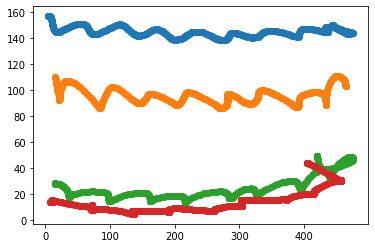

In [541]:
for i in (0, 2, 4, 6):
    segnali[i]=segnali[i][0:segnali[i+1].size]
    segnali[i+1]=segnali[i+1][0:segnali[i].size]
    plt.plot_date(segnali[i], segnali[i+1], xdate=False)

plt.show()

# Gif

Vado a creare una gif per evidenziare i movimenti della gamba nel tempo.

Prima di tutto importo le libreire:

In [542]:
import matplotlib.animation as animation
from IPython import display

Ora inizializzo il grafico:

In [543]:
min_x=min(min(segnali[0]),min(segnali[2]),min(segnali[4]),min(segnali[6]))
max_x=max(max(segnali[0]),max(segnali[2]),max(segnali[4]),max(segnali[6]))
min_y=min(min(segnali[1]),min(segnali[3]),min(segnali[5]),min(segnali[7]))
max_y=max(max(segnali[1]),max(segnali[3]),max(segnali[5]),max(segnali[7]))

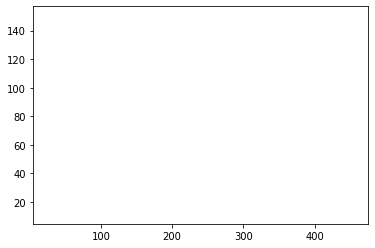

In [544]:
fig = plt.figure()
axis = plt.axes(xlim = (min_x, max_x),
                ylim = (min_y, max_y))

line, = axis.plot([], [], lw = 2)

In [545]:
def init():
    line.set_data([], [])
    return line,

Creo la funzione che andrà a restituire i singoli punti:

In [546]:
# function takes frame as an input
def animate(frame):
    xdata, ydata = [], []
    for i in (0,2,4,6):
        if(frame<len(segnali[i])):
            x=segnali[i][frame]
            xdata.append(x)
           
        if(frame<len(segnali[i+1])):
            y=segnali[i+1][frame]
            ydata.append(y)
        
    line.set_data(xdata, ydata)
    return [line]

Ora creo la Gif e la salvo:

In [547]:

frames=len(segnali[0])#da controllare
print(frames)

anim = animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames=frames,
                            interval = 20,
                            blit = True)
plt.show()

583


In [548]:
anim.save('gamba.mp4', writer = 'ffmpeg', fps = 30)

# Numero passi per gamba

Può essere interezzante vedere se il paziente fa più passi con una gamba rispetto all'altra.

In [549]:
def getData(patient):
    percorso="/home/davide/Documents/FESI"
    # qui metti il path al file .mat sul tuo pc (compreso .mat)
    data = loadmat(
        percorso+"/Pazienti/"+patient+".mat")
    data_filter = data[list(data.keys())[-1]]

    anca_x = nanRem(data_filter[:,0])
    anca_y = nanRem(data_filter[:,1])
    ginocchio_x = nanRem(data_filter[:,2])
    ginocchio_y = nanRem(data_filter[:,3])
    caviglia_x = nanRem(data_filter[:,4])
    caviglia_y = nanRem(data_filter[:,5])
    piede_x = nanRem(data_filter[:,6])
    piede_y = nanRem(data_filter[:,7])

    segnali=[anca_x, anca_y, ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x, piede_y]

    inverti_y(segnali)
    inverti_x(patient, segnali)
    pulizia(segnali)
    return segnali
#fare la trasposta

Conto i picchi nella derivata prima i quali corrispondono al numero di passi del soggetto.

Prima analizzo la gamba sinistra:

In [550]:
def numSteps(patient):
    segnali=getData(patient)
    plt.plot(segnali[5], "r")
    plt.show()

    der=np.gradient(segnali[5])
    plt.plot(der)
    plt.show()

    filt_cut = der
    filt_cut += np.max(der)
    peaksL, _ = find_peaks(filt_cut, np.mean(der), distance=40)
    plt.plot(filt_cut)
    plt.plot(peaksL, filt_cut[peaksL], "x")
    plt.show()
    return len(peaksL)

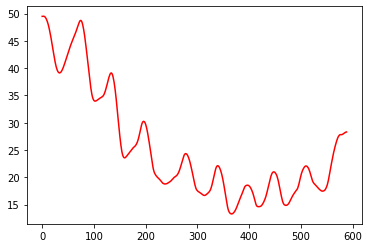

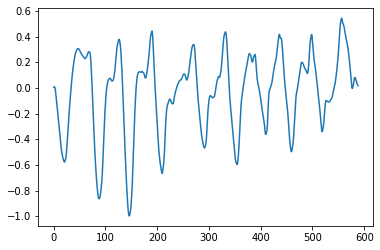

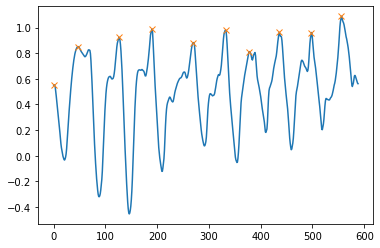

Il numero di passi della gamba sinistra del paziente 522 è: 10

In [551]:
md("Il numero di passi della gamba sinistra del paziente 522 è: {}".format(numSteps("522_01_L_joints")))

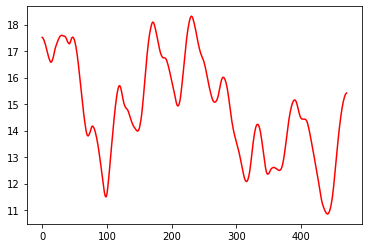

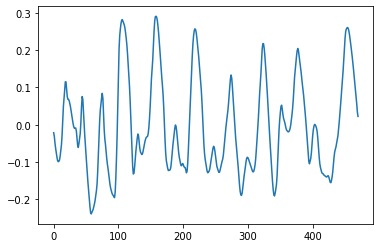

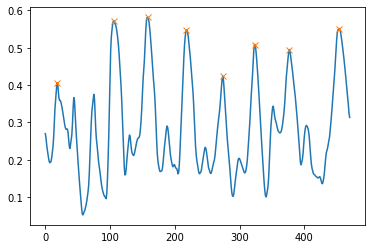

Il numero di passi della gamba destra del paziente 522 è: 8

In [552]:
md("Il numero di passi della gamba destra del paziente 522 è: {}".format(numSteps("522_01_R_joints")))

# Distanza tra i passi

Andiamo ad analizzare la distanza tra i passi:

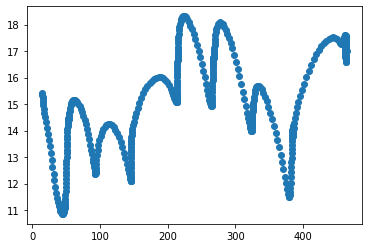

In [554]:
plt.plot_date(segnali[4], segnali[5],xdate=False)
plt.show()

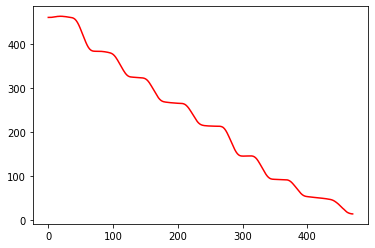

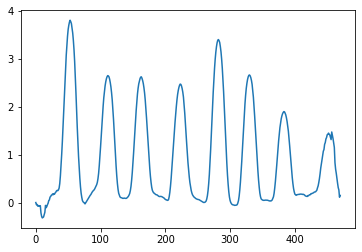

In [555]:
plt.plot(segnali[4], "r")
plt.show()

der=np.gradient(-segnali[4])
plt.plot(der)
plt.show()

La distanza tra i picchi è il tempo intercorso tra un passo e un altro (o meglio da metà di un passo a metà di quello dopo)

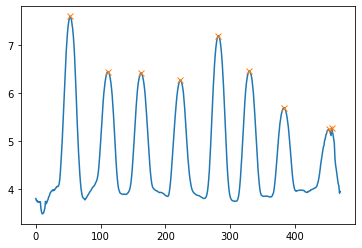

In [556]:
filt_cut = der
filt_cut += np.max(der)
peaks, _ = find_peaks(filt_cut, np.mean(der))
plt.plot(filt_cut)
plt.plot(peaks, filt_cut[peaks], "x")
plt.show()

Questi sono i picchi:

In [557]:
print(peaks)

[ 53 111 163 223 282 330 383 452 457]


La distanza media tra uno e l'altro è:

In [558]:
dist=[]
for i in range(len(peaks)-1):
    dist.append(abs(peaks[i]-peaks[i+1]))
print(dist)

[58, 52, 60, 59, 48, 53, 69, 5]


In [559]:
n=int(np.mean(dist))
md("In media la distanza tra un passo e l'altro è di un paziente è di {} frame che corrispondono a {} secondi".format(n, n/25))

In media la distanza tra un passo e l'altro è di un paziente è di 50 frame che corrispondono a 2.0 secondi

Andiamo a vedere la distanza tra un passo e l'altro di un soggetto sano.

Carico i dati:

In [560]:
sano = 'S004_sx'  # nome del file (senza .mat)
# qui metti il path al file .mat sul tuo pc (compreso .mat)
data = loadmat(
    percorso+"/"+sano+".mat")
data_filter = data[list(data.keys())[-1]]

In [561]:
segnaliSano=[]
for i in range(8):
    segnaliSano.append(nanRem(data_filter[:,i]))

Plotto il movimento della caviglia:

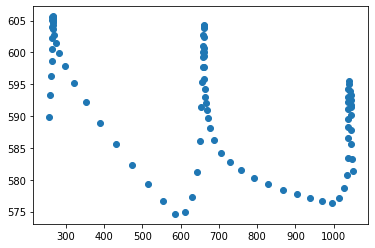

In [562]:
plt.plot_date(segnaliSano[4], segnaliSano[5],xdate=False)
plt.show()

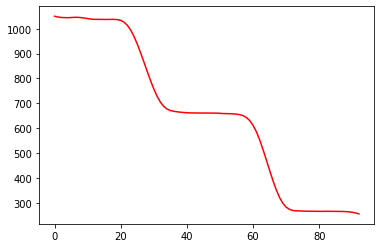

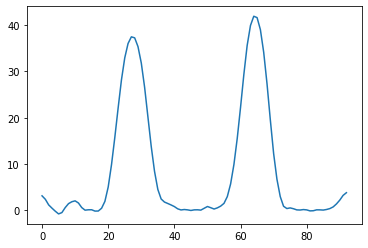

In [563]:
plt.plot(segnaliSano[4], "r")
plt.show()

der=np.gradient(-segnaliSano[4])
plt.plot(der)
plt.show()

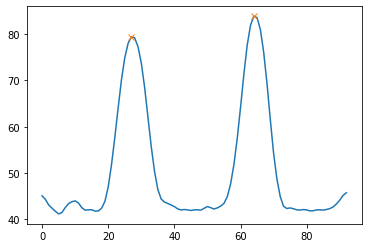

In [564]:
filt_cut = der
filt_cut += np.max(der)
peaks, _ = find_peaks(filt_cut, np.mean(der))   #distance è la disntanza tra i picchi
plt.plot(filt_cut)
plt.plot(peaks, filt_cut[peaks], "x")
plt.show()

In [565]:
dist=[]
for i in range(len(peaks)-1):
    dist.append(abs(peaks[i]-peaks[i+1]))
n=int(np.mean(dist))
md("In media la distanza tra un passo e l'altro è di un soggetto sano è di {} frame che corrispondono a {} secondi".format(n, n/25))

In media la distanza tra un passo e l'altro è di un soggetto sano è di 37 frame che corrispondono a 1.48 secondi

Sembrerebbe che i pazienti camminando tendato a lasciare il piede per più tempo poggiato a terra rispetto ai soggetti sani.

Andiamo a verificare l'ipotesi prendendo la media dei tempi dei soggetti sani e confrontatndola con quella dei pazienti.

Prima esaminiamo i pazienti:

In [566]:
def tempoPasso(targetPattern):
    mean=[]
    for file in (glob.glob(targetPattern)):
        #print(file)
        #carico i file
        data = loadmat(file)
        data_filter = data[list(data.keys())[-1]]
        segnali=[]
        for i in range(8):
            #rimuovo i nan
            segnali.append(nanRem(data_filter[:,i]))
        #invero l'asse y
        inverti_y(segnali)
        #invero l'asse x per i file contenenti dati seulle gambe di destra
        inverti_x(file, segnali)
        #pulisco i segnali
        pulizia(segnali)
        #calcolo la derivata
        der=np.gradient(-segnali[4])
        filt_cut = der
        filt_cut += np.max(der)
        #trovo i picchi
        peaks, _ = find_peaks(filt_cut, np.mean(der))
        '''plt.plot(filt_cut)
        plt.plot(peaks, filt_cut[peaks], "x")
        plt.show()'''
        dist=[]
        #calcolo la distanza tra i picchi
        #se nella registrazione c'è solo un picco non ha senso calcolare la distanza
        if(len(peaks)!=1):
            for i in range(len(peaks)-1):
                dist.append(abs(peaks[i]-peaks[i+1]))
            mean.append(int(np.mean(dist)))            
    return(np.mean(mean)/25)

In [567]:
tempo=tempoPasso(percorso+"/Pazienti/*.mat")
md("In media i pazienti impiegano {} secondi a fare un passo".format(tempo))

In media i pazienti impiegano 1.9015384615384616 secondi a fare un passo

In [568]:
tempo=tempoPasso(percorso+"/*.mat")
md("In media i soggetti sani impiegano {} secondi a fare un passo".format(tempo))

In media i soggetti sani impiegano 1.305 secondi a fare un passo

# Tempo in cui il piede rimane a terra

Andiamo ora ad analizzare per quanto tempo il soggetto tiene il piede poggiato a terra duratìnte la camminata.

Sfruttando la derivata posso capire quando il piede sta fermo e quindi quando è poggiato a terra.

In [569]:
segnali=getData("241_02_R_joints")

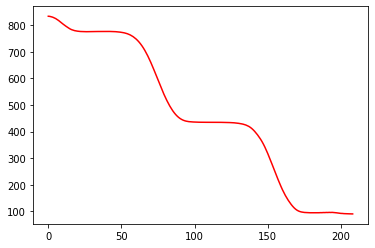

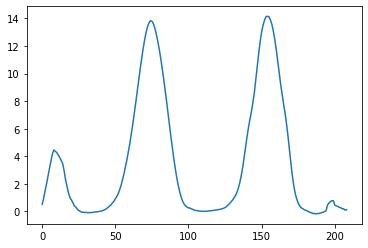

In [570]:
plt.plot(segnali[4], "r")
plt.show()

der=np.gradient(-segnali[4])
plt.plot(der)
plt.show()

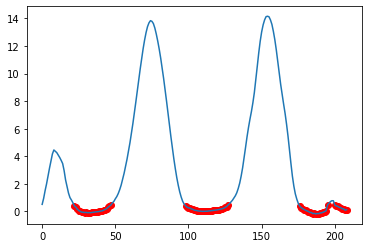

[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 200, 201, 202, 203, 204, 205, 206, 207, 208]


In [571]:
frames=[]
frame=0
for point in der:
    if point<0.5 and point>-0.5:
        plt.plot(frame,point, marker="o", color="red")
        frames.append(frame)
    frame+=1
plt.plot(der)
plt.show()

print(frames)

Ora divido i frame nei quali il piede è a terra tra un passo e l'altro, infatti se la distanza tra un frame e quello dopo è maggiore di un certo numero significa che il soggetto ha fatto un passo e che ora il piede è di nuovo a terra

In [572]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
def piedeTerra(frames):
    split=[]
    for i in range(len(frames)):
        if i < len(frames)-1:
            #se la distanza tra un frame è maggiore di 5 divido l'array
            if frames[i+1] - frames[i]  > 5:
                split.append(i+1)
    return np.array_split(frames, split)

In [573]:
terra=np.asarray(piedeTerra(frames))
print(terra)

[array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47])
 array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
        124, 125, 126, 127])
 array([176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 191, 192, 193, 194, 195, 200, 201, 202, 203, 204, 205,
        206, 207, 208])                                                 ]


Ora calcolo la media dei tempi in cui il piede rimane a terra

In [574]:
def mediaTerra(frames):
    media=[]
    for i in range(len(frames)):
        media.append(len(frames[i]))
    return np.mean(media)

In [575]:
media = mediaTerra(terra)
md("In media il piede durante la camminata sta poggiato a terra per {} secondi".format(media/25))

In media il piede durante la camminata sta poggiato a terra per 1.1333333333333333 secondi

Ora eseguo la stessa procedura prima con tutti i pazienti e poi con tutti i soggetti sani per confrontare così i risultati.

In [576]:
def frameTerra(targetPattern):
    mean=[]
    for file in (glob.glob(targetPattern)):
        #print(file)
        #carico i file
        data = loadmat(file)
        data_filter = data[list(data.keys())[-1]]
        segnali=[]
        for i in range(8):
            #rimuovo i nan
            segnali.append(nanRem(data_filter[:,i]))
        #invero l'asse y
        inverti_y(segnali)
        #pulisco i segnali
        pulizia(segnali)
        #calcolo la derivata

        der=np.gradient(-segnali[4])
        frames=[]
        frame=0
        for point in der:
            if point<0.5 and point>-0.5:
                #plt.plot(frame,point, marker="o", color="red")
                frames.append(frame)
            frame+=1
        value=mediaTerra(np.asarray(piedeTerra(frames)))
        #tolgo valori da value = 1 poichè sono dovuti ad una errata registrazione del piede a terra
        if value!=1:
            mean.append(value)
    return(np.mean(mean)/25)

In [577]:
tempo=frameTerra(percorso+"/Pazienti/*.mat")
md("In media i pazienti duarnte la camminata tengono poggiato il piede per {} secondi ".format(tempo))

In media i pazienti duarnte la camminata tengono poggiato il piede per 0.6362641802641803 secondi 

In [578]:
tempo=frameTerra(percorso+"/*.mat")
md("In media i soggetti sani durante la camminata tengono poggiato il piede per {} secondi".format(tempo))

In media i soggetti sani durante la camminata tengono poggiato il piede per 0.212 secondi

# Altezza dei passi

Andiamo ora a misurare l'altezza dei passi del paziente per vedere se alza di più la gamba destra o la sinistra:

Plotto i valori della caviglia sull'asse y

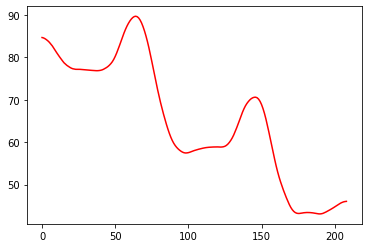

In [579]:
plt.plot(segnali[5], "r")
plt.show()

Ora trovo i picchi e le valli. Il valore dei picchi è ottenuto sottraendo all'altezza del picco il valore più basso delle y, in questo modo il picco indica l'altezza del passo.

Picchi:

In [580]:
def peaksFinder(y):
    peaksValue=[]
    filt_cut = y
    filt_cut += np.max(np.abs(y))
    peaks, _ = find_peaks(filt_cut, 0)
    plt.plot(filt_cut)
    plt.plot(peaks, filt_cut[peaks], "o")
    plt.show()
    for peak in peaks:
        peaksValue.append(y[peak])
    return peaksValue

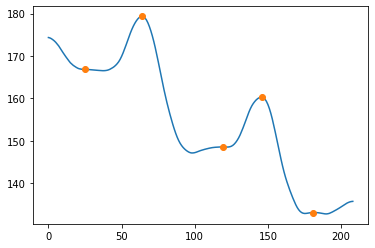

[34.10282109 46.61026958 15.80026721 27.51851819  0.33246419]


In [581]:
peaks=peaksFinder(segnali[5])
peaks=peaks-min(segnali[5])
print(peaks)

Valli:

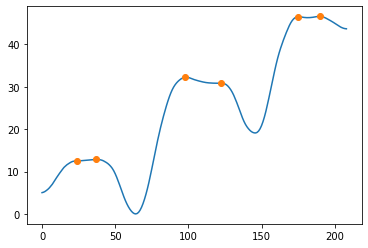

[12.51614897585415, 12.835917625834725, 32.24160301207547, 30.846778801285836, 46.503032978454996, 46.61026957505695]


In [582]:
valleys=peaksFinder(-segnali[5])
print(valleys)

Prendo il secondo picco e la terza valle e calcolo la distanza tra i due:

In [583]:
altezza=abs(peaks[1]-valleys[2])
print(altezza)

14.368666562981474


Faccio la stessa cosa con il quarto picco e la quinta valle

In [584]:
altezza=abs(peaks[3]-valleys[5])
print(altezza)

19.09175138129376


Il paziente con la gamba sinistra fa dei passi che sono all'incirca alti uguali.

Ora osservo la gamba destra:

In [585]:
percorso="/home/davide/Documents/FESI"
patient = '211_01_R_joints'  # nome del file (senza .mat)
# qui metti il path al file .mat sul tuo pc (compreso .mat)
data = loadmat(
    percorso+"/Pazienti/"+patient+".mat")
data_filter = data[list(data.keys())[-1]]

Ora calcolo la distanza tra il valore medio dei picchi e il valore medio delle valli:

5.3860904435439565


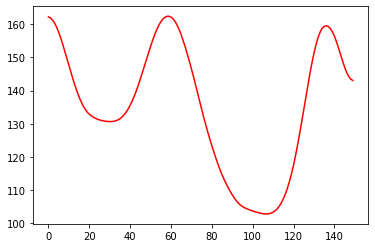

In [586]:
altezzaMedia=np.abs(np.mean(peaks)-np.mean(valleys))
print(altezzaMedia)

anca_x = nanRem(data_filter[:,0])
anca_y = nanRem(data_filter[:,1])
ginocchio_x = nanRem(data_filter[:,2])
ginocchio_y = nanRem(data_filter[:,3])
caviglia_x = nanRem(data_filter[:,4])
caviglia_y = nanRem(data_filter[:,5])
piede_x = nanRem(data_filter[:,6])
piede_y = nanRem(data_filter[:,7])

segnali=[anca_x, anca_y, ginocchio_x, ginocchio_y, caviglia_x, caviglia_y, piede_x, piede_y]

pulizia(segnali)

inverti_y(segnali)

inverti_x(patient, segnali)

plt.plot(segnali[5], "r")
plt.show()

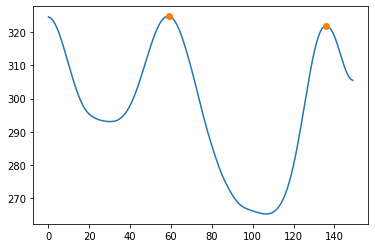

[324.8286486722434, 321.9492124907224]


In [587]:
peaks=peaksFinder(segnali[5])
print(peaks)

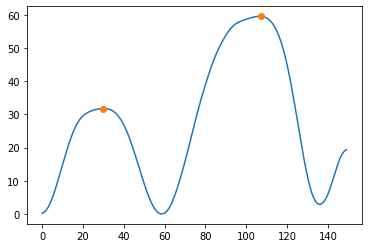

[31.76787506933249, 59.60648727514331]


In [588]:
peaks=peaksFinder(-segnali[5])
print(peaks)

Osservo la distanza tra il secondo picco e la terza valle:

In [589]:
altezza=abs(peaks[1]-valleys[2])
print(altezza)

27.364884263067836


Adesso faccio lo stesso procedimento con tutti i pazienti e tutti i soggetti sani:

In [590]:
def altezzaPassi(targetPattern):
    altezze = []
    for file in (glob.glob(targetPattern)):
        # print(file)
        # carico i file
        data = loadmat(file)
        data_filter = data[list(data.keys())[-1]]
        valori = []
        for i in range(8):
            # rimuovo i nan
            valori.append(nanRem(data_filter[:, i]))
        # invero l'asse y
        inverti_y(valori)
        # invero l'asse x per i file contenenti dati seulle gambe di destra
        inverti_x(file, valori)
        # pulisco i segnali
        pulizia(valori)
        peaks = peaksFinder(valori[5])
        #print(peaks)
        valleys = peaksFinder(-valori[5])
        altezze.append(np.mean(peaks)-np.mean(valleys))
    return np.mean(altezze)


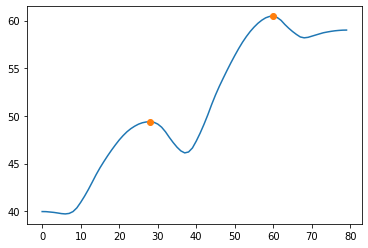

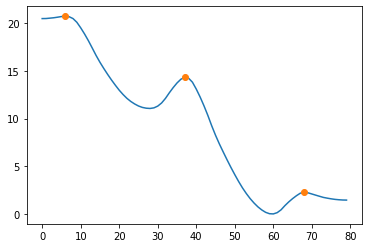

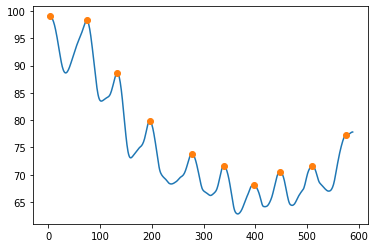

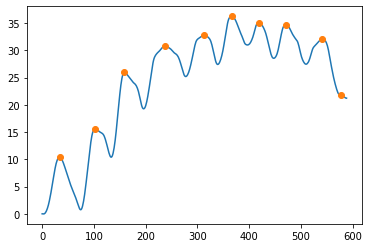

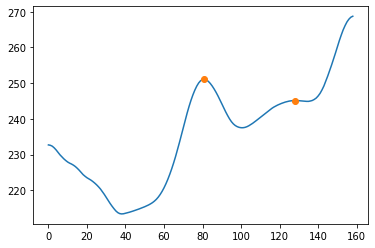

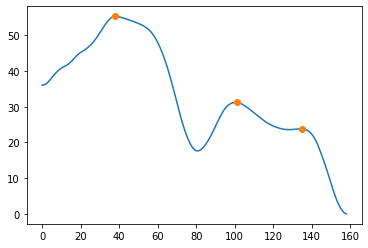

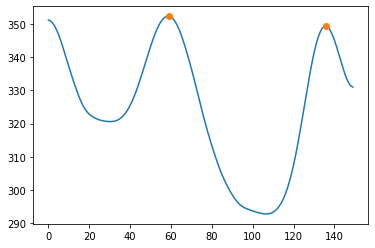

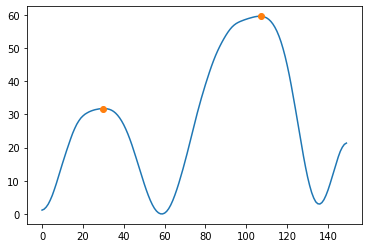

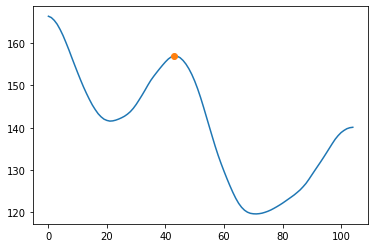

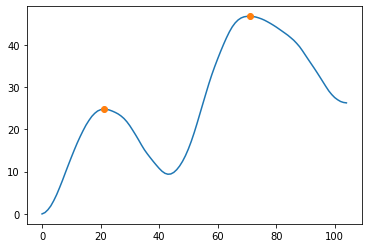

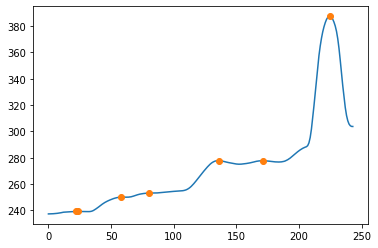

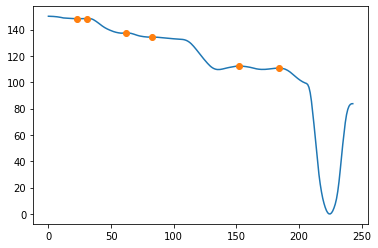

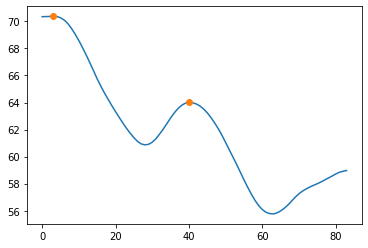

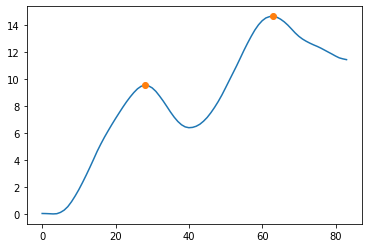

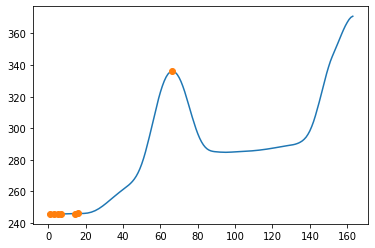

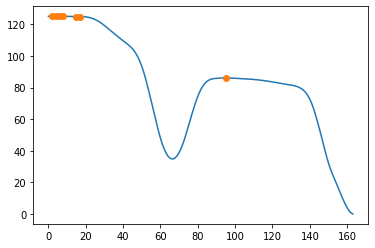

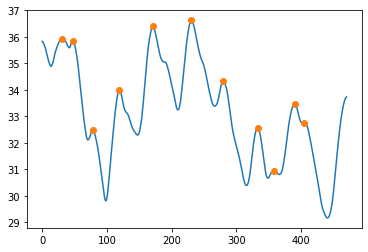

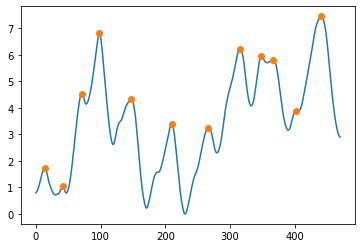

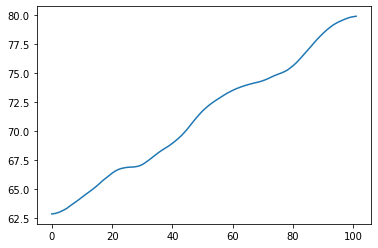

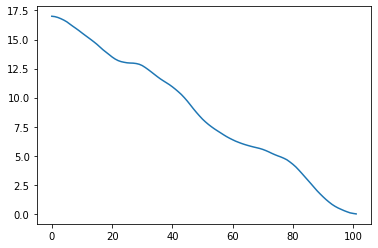

/home/davide/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/davide/.local/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


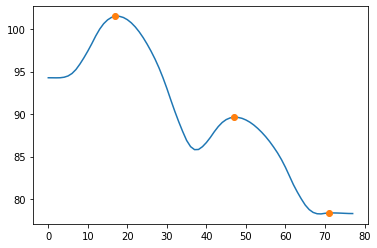

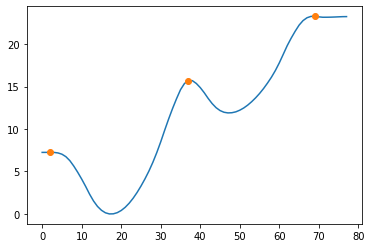

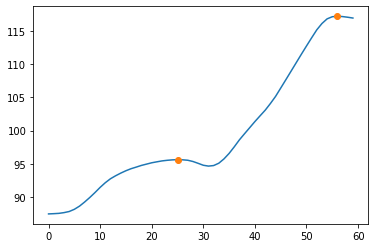

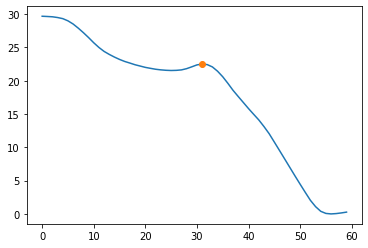

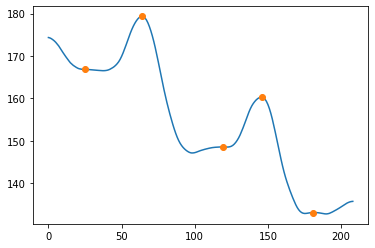

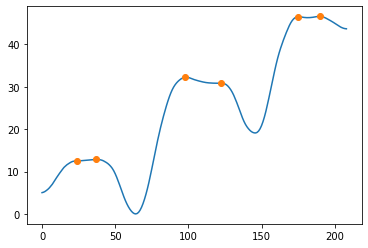

In media i pazienti alzano il piede di nan

In [591]:
altezza=altezzaPassi(percorso+"/Pazienti/*.mat")
md("In media i pazienti alzano il piede di {}".format(altezza))

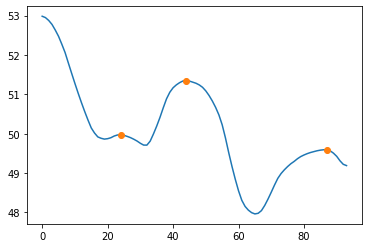

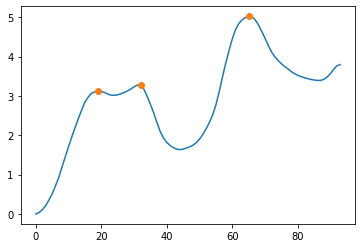

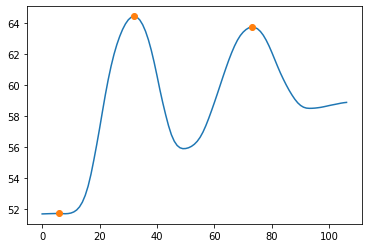

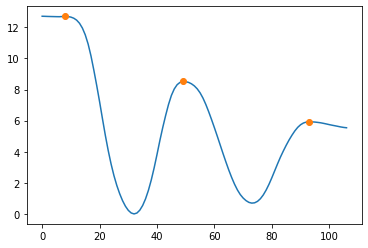

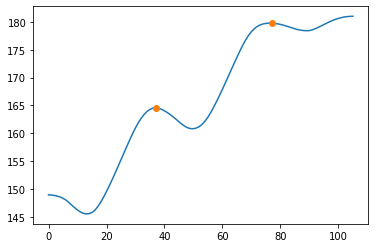

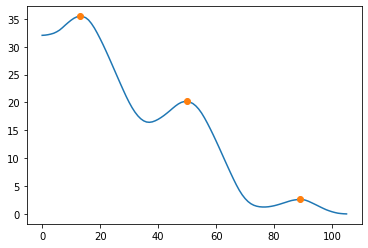

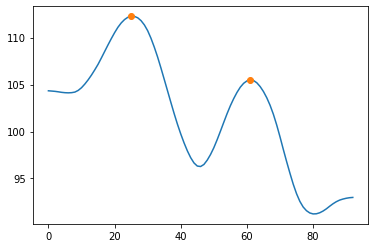

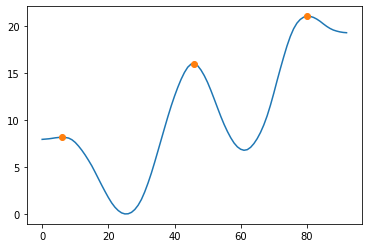

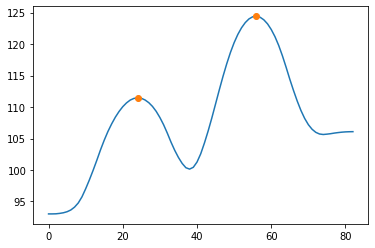

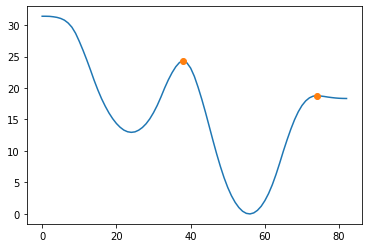

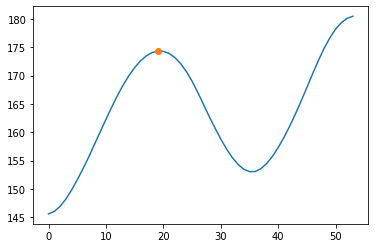

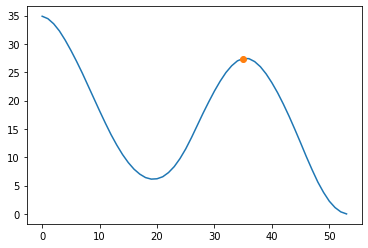

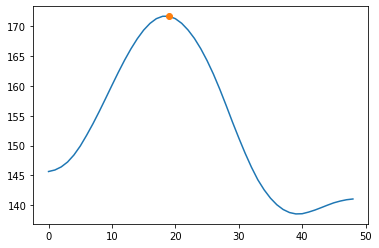

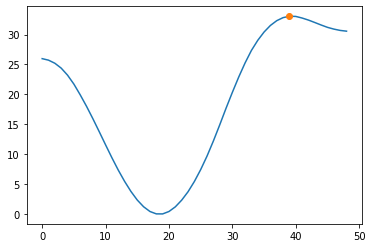

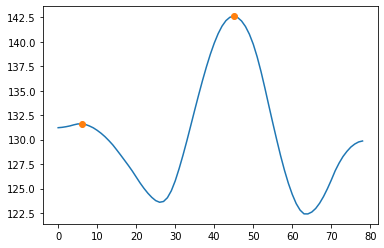

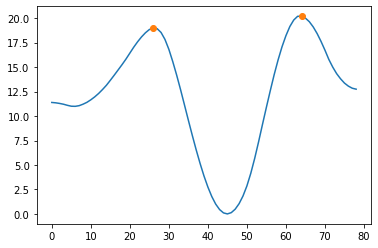

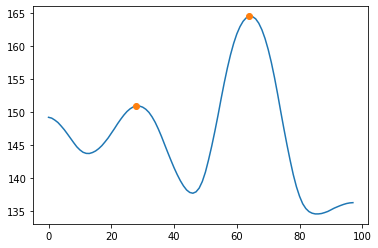

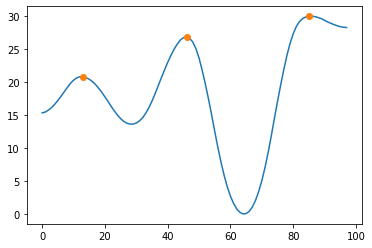

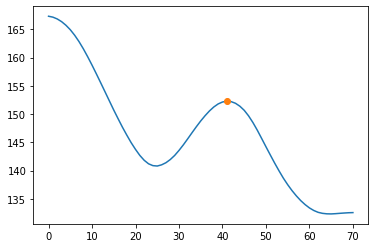

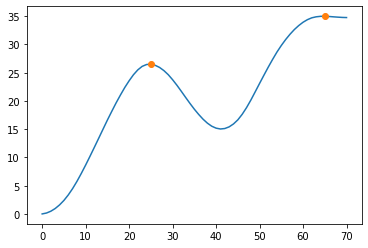

In media i soggetti sani alzano il piede di 109.67649109342169

In [592]:
altezza=altezzaPassi(percorso+"/*.mat")
md("In media i soggetti sani alzano il piede di {}".format(altezza))